# Switching dynamical systems
by Magdalena Buszka, Martyna Firgolska, Karol Kuczmarz

## Motivation

Our main motivation for this project was to understand HMM and Normalizing Flows and combine this models in order to create a model that will be able to recognize hidden discrete variables (hidden states) given continous observable variables. 

## Our model

Our model consists of Hidden Markov Model combined with continuous probability distributions modeled and trained by Normalizing Flows (RealNVP).

### HMM

#### What is HMM?


HMM - Hidden Markov Model is based on Markov chain. Markov chain is a model used to predict sequence of discreete variables (states). It assumes that if we want to predict next state in a sequence then all that is important is current state. In other words it does not matter how we got into current state.  

In hidden markov model we assume that there are some hidden discreete states that form a markov chain. This hidden states dictate probabilities with which observable discreete vairables are drawn. Given sequences of observable variables hidden marcov model can be trained to create underlying marcov chain of hidden discreete states and most likely probablity distributions of observable variables for each hidden state. It is achieved using dynamic forward, backward and forward-backward algorithm. Given trained model and sequence of observable variables we can predict most likely hidden state sequence by using viterbi algorithm.

Good resource for learning more about HMMs: https://web.stanford.edu/~jurafsky/slp3/A.pdf

#### How we modified HMM for our use?

The classic Hidden Markov Model is used to model markov processes with discreete observable variables. However in our aplication we wanted our observable variables to be from continous distributions. This changes the theoretical model in two major ways. Firstly now instead of operating on probability of observation given hidden state we are using probablity density function (pdf). However this theoretical change does not change algorithms much. Secondly we need another way to model and train probabilities of observations for each state - this is where Normalizing Flows are used - they will be described in later section.

For testing purposes for HMM model we used torch.distributions as a way to model probablity distributions of observations for each state and did not train them. Instead we focused on training transition matrix, since training for distributions will be part of normalizing flow model.

We modified code from
https://github.com/lorenlugosch/pytorch_HMM
We changed emission model to be continous distribution. We also added backward and forward-backward algorithms. All algorithms are written in log domain for better numerical stablility.

### HMM demo

In [ ]:
# TODO imports
from models.hmm.HiddenMarkovModel import *
from models.hmm.ArtificialDatasetFromHMM import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

/home/martyna/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


#### Using HMM class to generate samples
HMM class can be used to generate samples. It takes observation distributions for each state as an argument. As a default it generates random transition matrix (but transition matrix can be given as an argument too).

1D samples

transition matrix:
 tensor([[0.2683, 0.7317],
        [0.7338, 0.2662]])
samples
 tensor([ 2.9232, -2.0618,  1.1482, -1.1245,  0.5543, -0.5431, -1.6209, -0.3294,
        -1.6251,  0.5588, -0.6268, -0.4577, -0.0465, -0.8909, -0.5054,  0.2506,
         0.1254, -1.8412,  1.0411, -2.1332])
hidden states:
 [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]


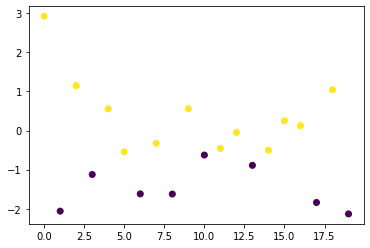

In [ ]:
# two hidden states
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])
x, z = test_model.sample(20)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
print("samples\n", x)
print("hidden states:\n", z)
plt.scatter(list(range(len(x))),x, c=z)

transition matrix:
 tensor([[0.4615, 0.0718, 0.4668],
        [0.2197, 0.4638, 0.3164],
        [0.5363, 0.3013, 0.1624]])


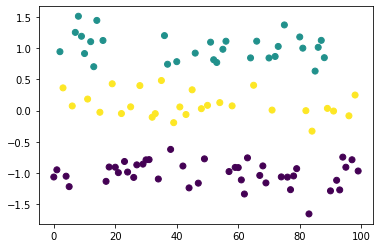

In [ ]:
# three hidden states
test_model = HMM(3, [distrib.Normal(-1,0.2), distrib.Normal(1, 0.2), distrib.Normal(0,0.2)])
x, z = test_model.sample(100)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
plt.scatter(list(range(len(x))),x, c=z)

2D samples

transition matrix:
 tensor([[0.7289, 0.2711],
        [0.5681, 0.4319]])


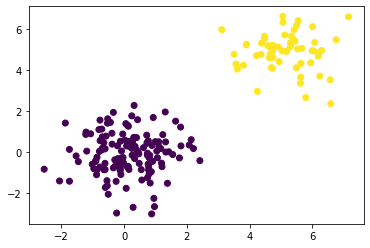

In [ ]:
test_model = HMM(2, [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))])
x, z = test_model.sample(200)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
plt.scatter(x[:,0],x[:,1], c=z)

##### Training HMMs
We use HMM model to generate samples and then train another HMM model on this data. We only use x (observable vairables) for training. 

In [ ]:
sequence_length, n_of_sequences, sample_dim = 100, 1000, 2
batch_size = 500
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))],
    device, 
    T=n_of_sequences,
    sequence_length=sequence_length,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.7, 0.3]]))
samples = my_dataset[1:len(my_dataset)]


In [ ]:
HMM_to_train = HMM(2,[distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))], 
                   transition_matrix = torch.Tensor([[0.49,0.51],[0.55, 0.45]]))
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Starting transition matrix:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])
Starting transition matrix:
 tensor([[0.4900, 0.5100],
        [0.5500, 0.4500]])


In [ ]:
from torch.utils.data import DataLoader
# dataset is class inheriting from torch.utils.data.Dataset
for epoch in range(10):
    dataloader = DataLoader(my_dataset, batch_size= batch_size)
    for batch, x in enumerate(dataloader):
        T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
        HMM_to_train.forward_backward_step(x, T)
        #print(HMM_to_train.transition_model.normalized_transition_matrix())

In [ ]:
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Transition matrix after training:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])
Transition matrix after training:
 tensor([[0.1049, 0.8951],
        [0.6990, 0.3010]])


##### Using viterbi algorithm on trained model
We draw samples from original HMM model and attempt to assign them hidden states using the viterbi algorithm on trained model and observable variables.

short sequence

In [ ]:
sequence_length = 20
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob


tensor([[-64.2616]])

In [ ]:
print("original states:  ", z)
print("predicted states: ",viterbi_states[0])

original states:   [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
predicted states:  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


long sequence

In [ ]:
sequence_length = 200
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob


tensor([[-660.7247]])

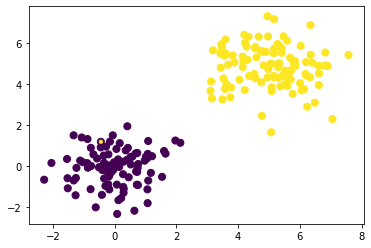

In [ ]:
plt.scatter(x[:,0],x[:,1], c=z, s=50)
plt.scatter(x[:,0],x[:,1], c=viterbi_states[0], s=10)

### Normalizing Flows

Normalizing flows are a method designed for learning the probability distributions of large datasets. We model the complex probability distribution as a base distribution (most often multivariate normal distribution) on which we apply a series of transformations. The main idea is for the transformations to be invertible - that way we can sample from the target distribution by sampling the known base distribution and applying the change of variables formula 

Let us denote  the observed data variable as $x\in X$, and the latent variables $z \in Z$. We assume that $x = g(z)$ for some invertible funstion $g$, where $f = g^{-1}$. We can then describe the distribution of $x$ by the change of variables formula:
$$
p_X(x) = p_Z(f(x)) \cdot|\det(\frac{\partial f}{\partial x^T})|
$$
taking the logarithm of both sides we get
$$\log(p_X(x)) = \log(p_Z(f(x))) +  \log\Big(\Big|\det(\frac{\partial f}{\partial x^T})\Big|\Big)$$
this means that by having the transformation for which we can compute the determinant of the Jacobian efficently we can efficently sample (by sampling the base distribution and applying $g$) and compute density at point $x$ (by computing the density of the base distribution at point $f(x)$ and multipling by the determinant of the Jacobian)

#### RealNVP (real non-volume preserving) transformations

The main idea of RealNVP is to exploit that the determinant of the triangular matrix is the product of the diagonal terms. Given the $D$ dimensional input and taking $d = D/2$ we set:
$$
y_{1:d} = x_{1:d} \\
y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})
$$
let us observe that the functions $s$ and $t$ can be as complex as we want and do not have to be invertible for the whole transform to be invertible as the inverse is simply
$$
x_{1:d} = y_{1:d} \\
x_{d+1:D} = (y_{d+1:D} - t(x_{1:d}))\odot \exp(-s(x_{1:d}))
$$
We will model $s$ and $t$ with neural networks.

The Jacobian of this trasformation is 
$$
\begin{bmatrix}
\mathbb{I}_d & 0\\
\frac{\partial y_{d+1:D}}{\partial{x^T_{1:d}}}& diag(\exp(s(x_{1:d})))
\end{bmatrix}
$$
and its deteriminant can be efficently computed as $\exp(\sum_j s(x_{1:d})_j)$

By appling many such layers alternated by changing places of $x_{1:d}$ and $x_{d+1:D}$ we obtain a highly flexible model capable of learning complex distributions. 



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
import torch.optim as optim
import torch.utils.data 

# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
import math

from tqdm.auto import tqdm

from models.nf.NormalizingFlow import *

#### Moons data demo

We present that the RealNVP normalizing flow works by using it to learn the distribution of the moons dataset. We train the model using negative loglikelihood. 

The real data:

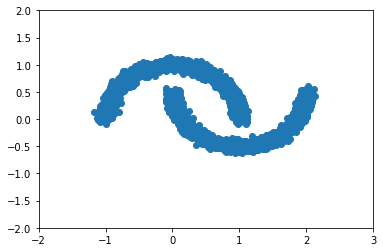

In [4]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
my_moons = MoonDataset(device, 5000)
batch_size = 256
moons_dataloader = torch.utils.data.DataLoader(my_moons, batch_size=batch_size,
                        shuffle=False)
x = my_moons.moons
plt.scatter(x[:, 0], x[:, 1])
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()

Training epoch 1 ...


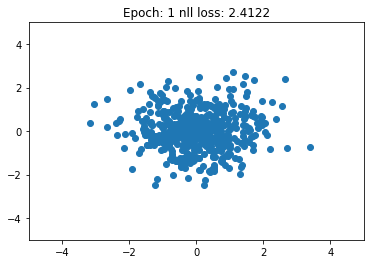

Training epoch 51 ...


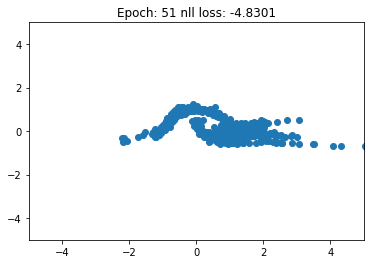

Training epoch 101 ...


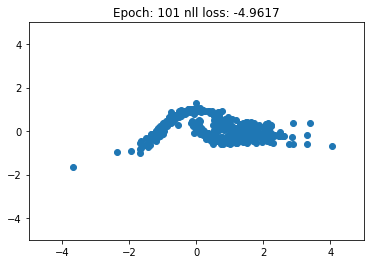

Training epoch 151 ...


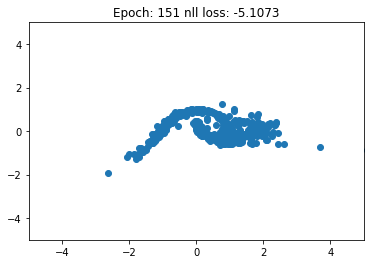

Training epoch 201 ...


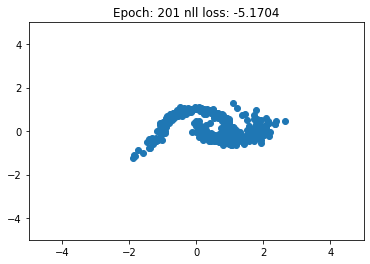

Training epoch 251 ...


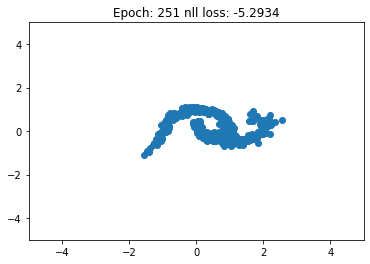

Training epoch 301 ...


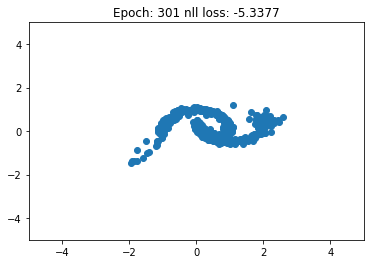

In [15]:
torch.manual_seed(0)
ref_distrib = distrib.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
block = [CouplingFlow, ReverseFlow]
flow = NormalizingFlow(dim = 2, device = device, blocks = block, flow_length = 8, base_distrib = ref_distrib, n_hidden = 128, n_layers = 3)
batch_size = 256
moons_dataloader = torch.utils.data.DataLoader(my_moons, batch_size=batch_size,
                        shuffle=False)
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=0.0003, weight_decay=0.0001)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
train_flow(flow, moons_dataloader, nll_loss, optimizer, scheduler, device = device, epochs=301, plot_it=50, plot_sample=500)

Every 50 epochs we plot the sample from the trained destribution (we sample from normal distribution and compute $g(z)$). We can see that we aquired the distribution which is very similar to the target distribution.

## Other tests

### HMM training second example

In [ ]:
sequence_length, n_of_sequences, sample_dim = 100, 1000, 2
batch_size = 500
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2),torch.eye(2))],
    device, 
    T=n_of_sequences,
    sequence_length=sequence_length,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.4, 0.6]]))
samples = my_dataset[1:len(my_dataset)]

In [ ]:
HMM_to_train = HMM(2,[distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2),torch.eye(2))], 
                   transition_matrix = torch.Tensor([[0.45,0.55],[0.49, 0.51]]))
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Starting transition matrix:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.4000, 0.6000]])
Starting transition matrix:
 tensor([[0.4500, 0.5500],
        [0.4900, 0.5100]])


In [ ]:
from torch.utils.data import DataLoader
# dataset is class inheriting from torch.utils.data.Dataset
for epoch in range(10):
    dataloader = DataLoader(my_dataset, batch_size= batch_size)
    for batch, x in enumerate(dataloader):
        T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
        HMM_to_train.forward_backward_step(x, T)
        #print(HMM_to_train.transition_model.normalized_transition_matrix())

In [ ]:
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Transition matrix after training:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.4000, 0.6000]])
Transition matrix after training:
 tensor([[0.1234, 0.8766],
        [0.4010, 0.5990]])


In [ ]:
sequence_length = 200
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob

tensor([[-635.4651]])

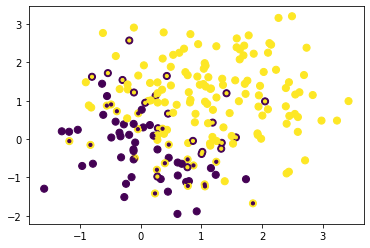

In [ ]:
plt.scatter(x[:,0],x[:,1], c=z, s=50)
plt.scatter(x[:,0],x[:,1], c=viterbi_states[0], s=10)

In [ ]:
print("error rate: ",(np.array(z)!=np.array(viterbi_states[0])).sum()/sequence_length)

error rate:  0.2
